## 4. Selección modelo final algoritmos de ML

### Objetivo

Proceso de entrenamiento y validación cruzada para la selección del mejor modelo de Machine Learning para cada uno de los clúster definidos en el proceso de clusterización.

### Descripción General de notebook

    1. Carga de data frame final
    2. Entrenamiento
    3. Validación cruzada
    4. Selección del Modelo final

In [1]:
from pandas import MultiIndex, Int16Dtype
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set_style('darkgrid')

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge,LinearRegression, LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [2]:
%run ".../.../Codigo/7. Prediccion/Funciones_Prepara_Prediccion.ipynb"

### Preparación datos

Se preparan los datos que van a ser utilizados en cada uno de los modelos a través de la función que ha sido diseñada llamada _dataBaseOriginal

In [3]:
bicimad = _dataBaseOriginal(".../.../Data/DataFrame_Final_Cierre_Cluster_2017_2019.csv")
bicimad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176477 entries, 0 to 176476
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ESTACION                  176477 non-null  int64  
 1   DEMANDA                   176477 non-null  float64
 2   MES_sen                   176477 non-null  float64
 3   MES_cos                   176477 non-null  float64
 4   TEMP_MAX                  176477 non-null  float64
 5   TEMP_MIN                  176477 non-null  float64
 6   HUMEDAD                   176477 non-null  float64
 7   VIENTO                    176477 non-null  float64
 8   PRESION                   176477 non-null  float64
 9   PRECIPITACION_1h          176477 non-null  float64
 10  PRECIPITACION_3h          176477 non-null  float64
 11  Es_Festivo_1              176477 non-null  uint8  
 12  Es_FinSemana_1            176477 non-null  uint8  
 13  TEMPORADA_OTONO           176477 non-null  u

Se definen las estaciones incluidas en cada uno de los clúster, los cuales estos fueron definidos a través de la demanda en la etapa de clusterización

In [4]:
datos = pd.read_csv("/Users/miguelflores/Desktop/TFM/Data/DataFrame_Final_Cierre_Cluster_2017_2019.csv", parse_dates=['FECHA'])

cluster0_estaciones = datos[datos['CLUSTER_soloDemanda']==0].ESTACION.unique()
cluster1_estaciones = datos[datos['CLUSTER_soloDemanda']==1].ESTACION.unique()
cluster2_estaciones = datos[datos['CLUSTER_soloDemanda']==2].ESTACION.unique()
cluster3_estaciones = datos[datos['CLUSTER_soloDemanda']==3].ESTACION.unique()
cluster4_estaciones = datos[datos['CLUSTER_soloDemanda']==4].ESTACION.unique()

# Comparación de Modelos

Para el entrenamiento de cada uno de los modelos se ha realizado lo siguiente:

 - Se selecciona los datos de cada uno de los clúster
 - Se separan los datos de entrenamiento y prueba aleatoriamente con un reparto de 70% de datos para entrenar y 30% de datos para validar los modelos
 - Se entrena cada uno de los modelos
 - Se realiza la validación cruzada de cada uno de los modelos a través de la metodología de RepeatedKFold considerando    n_splits=3 y n_repeats=5
 - Se determinan las métricas de los modelos (R2, MSE y RMSE)

Una vez determinados el mejor modelo para cada uno de los clúster a través de los resultados obtenidos en la validación cruzada, se ha procedido a entrenar el modelo final y a validar las métricas del mismo considerando los datos de entrenamiento y de prueba.


### Cluster 0

In [5]:
seed = 1234567

In [7]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster0_estaciones)]
train, test = train_test_split(bicimad_est, test_size = 0.30, random_state = seed)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']


models = list()
models.append(('RFR', RandomForestRegressor(bootstrap=True,
  max_depth=80,
  max_features=7,
  min_samples_leaf=1,
  min_samples_split=8,
  n_estimators=1000)))

models.append(('GBR', GradientBoostingRegressor(learning_rate=0.01,
  max_depth=80,
  n_estimators=500,
  subsample=0.2)))

models.append(('LGBMR', LGBMRegressor(learning_rate=0.1,
  max_depth=25,
  n_estimators=500,
  num_leaves=16)))

models.append(('XGBR', XGBRegressor(gamma=0.1,
  learning_rate=0.1,
  max_depth=8,
  min_child_weight=4,
  n_estimators=700,
  reg_alpha=0.1,
  reg_lambda=1)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    
    cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=seed)        
    cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True)
    
    cv_scores = pd.DataFrame(cv_scores)
    if name=='RFR':
        cv_scores_C0 = cv_scores.copy()
    else:
        cv_scores_C0 = pd.concat([cv_scores_C0, cv_scores])
        
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print(cv_scores)
    print()

Model: RFR 
R^2: 0.89.
MSE: 0.05
RMSE: 0.23
     fit_time  score_time  test_score  train_score
0   13.969565    0.875168    0.707375     0.889493
1   13.509420    0.872095    0.753912     0.884050
2   13.733166    0.880154    0.731131     0.887610
3   13.526676    0.900886    0.731594     0.887887
4   13.591902    0.904862    0.729262     0.887575
5   13.705410    0.850460    0.736844     0.886849
6   13.458753    0.856687    0.740348     0.886259
7   13.578547    0.861630    0.742177     0.886993
8   13.578403    0.935889    0.727547     0.886429
9   13.935621    0.959136    0.728858     0.886633
10  14.099753    0.859531    0.731422     0.888307
11  13.802440    0.870336    0.739965     0.885172
12  14.067807    0.886018    0.733819     0.886059
13  13.709816    0.870363    0.738644     0.887787
14  13.923180    0.990657    0.723891     0.887761

Model: GBR 
R^2: 0.94.
MSE: 0.06
RMSE: 0.23
     fit_time  score_time  test_score  train_score
0   12.052654    0.427335    0.713905     0.

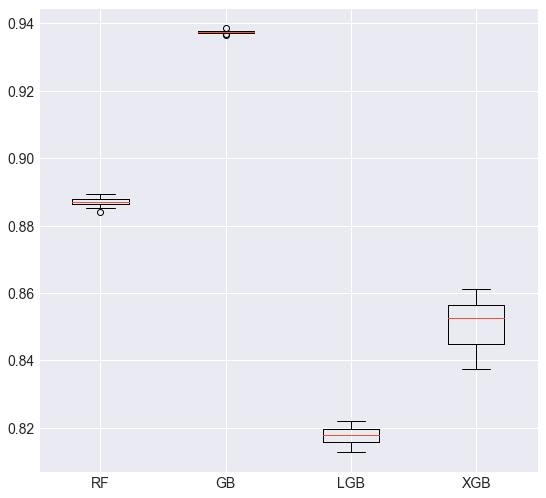

In [6]:
cv_scores_C0_test = cv_scores_C0.drop(['train_RF','train_GB','train_LGB','train_XGB'], axis=1)
cv_scores_C0_train = cv_scores_C0.drop(['test_RF','test_GB','test_LGB','test_XGB'], axis=1)

plt.figure(figsize=(8,8))
plt.boxplot(cv_scores_C0_train)
plt.xticks(range(1, len(names)+1), names)
plt.show()

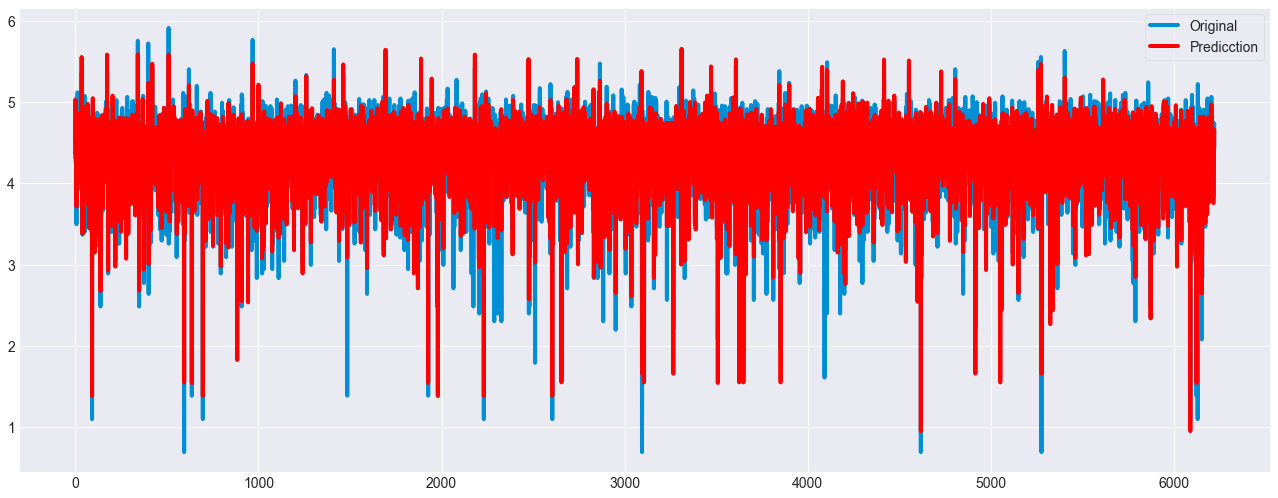

In [7]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster0_estaciones)]

train, test = train_test_split(bicimad_est, test_size = 0.20, random_state = seed)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']


model_C0 = GradientBoostingRegressor(learning_rate=0.01,
  max_depth=80,
  n_estimators=500,
  subsample=0.2)

resultado = model_C0.fit(X_train, y_train)

y_pred_train = model_C0.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mse_train**(0.5)
score_train = model_C0.score(X_train, y_train, sample_weight=None)

y_pred_test = model_C0.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_train**(0.5)
score_test = model_C0.score(X_test, y_test, sample_weight=None)


predictions = resultado.predict(X_test)
 
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

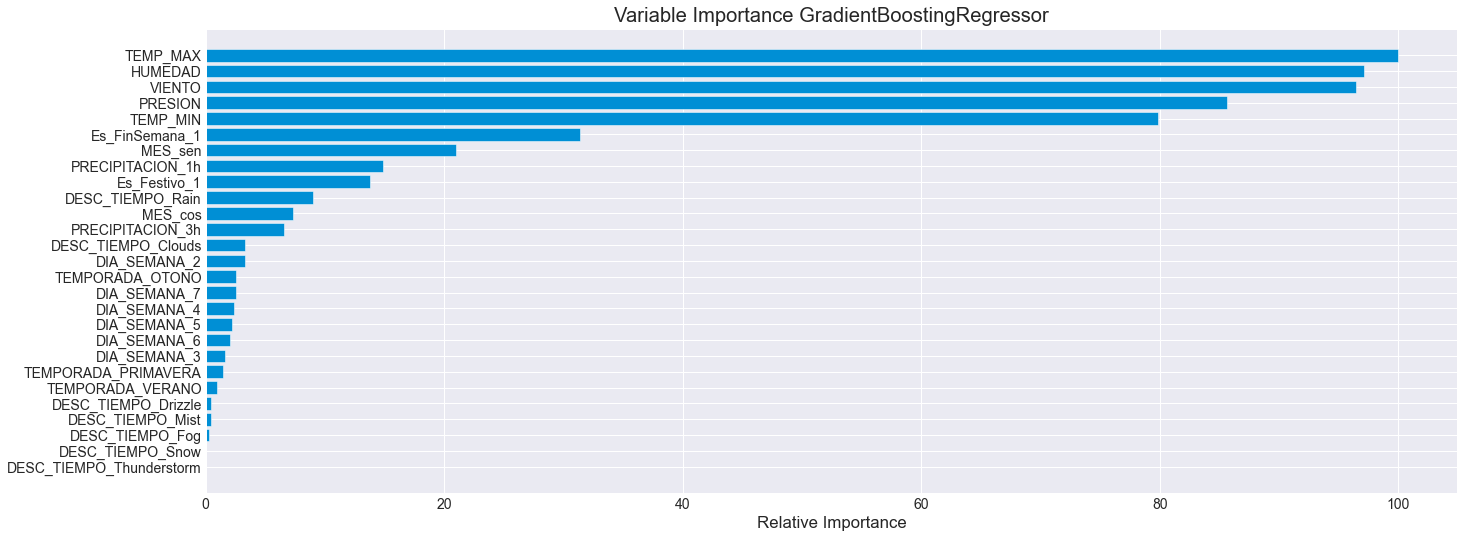

In [8]:
feature_importance = model_C0.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title(f'Variable Importance {model_C0.__class__.__name__}')
plt.show()

In [9]:
print('---------Evaluación del modelo en datos train---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_train))
print("Mean Absolute Error: %.2f" % mse_train)
print("Root Mean Squared Error: %.2f" % rmse_train)
print('')
print('---------Evaluación del modelo en datos test---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_test))
print("Mean Absolute Error: %.2f" % mse_test)
print("Root Mean Squared Error: %.2f" % rmse_test)

---------Evaluacióin del melo en datos train---------------
R^2 Coefficient of Determination: 0.94.
Mean Absolute Error: 0.01
Root Mean Squared Error: 0.12

---------Evaluacióin del melo en datos test---------------
R^2 Coefficient of Determination: 0.75.
Mean Absolute Error: 0.05
Root Mean Squared Error: 0.12


## Cluster 1

In [30]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster1_estaciones)]
    
train, test = train_test_split(bicimad_est, test_size = 0.30, random_state = 789391)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']
    

models = list()
models.append(('RFR', RandomForestRegressor(bootstrap=True,
  max_depth=80,
  max_features=7,
  min_samples_leaf=1,
  min_samples_split=8,
  n_estimators=1000)))

models.append(('GBR', GradientBoostingRegressor(learning_rate=0.01,
  max_depth=80,
  n_estimators=500,
  subsample=0.1)))

models.append(('LGBMR', LGBMRegressor(learning_rate=0.1,
  max_depth=25,
  n_estimators=1000,
  num_leaves=16)))

models.append(('XGBR', XGBRegressor(gamma=0,
  learning_rate=0.1,
  max_depth=8,
  min_child_weight=4,
  n_estimators=1000,
  reg_alpha=1,
  reg_lambda=200)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    
    cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=seed)        
    cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True)
    
    cv_scores = pd.DataFrame(cv_scores)
    if name=='RFR':
        cv_scores_C1 = cv_scores.copy()
    else:
        cv_scores_C1 = pd.concat([cv_scores_C1, cv_scores])
        
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print(cv_scores)
    print()

Model: RFR 
R^2: 0.89.
MSE: 0.05
RMSE: 0.23
     fit_time  score_time  test_score  train_score
0   18.523056    1.172788    0.730681     0.884507
1   18.363859    1.241658    0.722995     0.882984
2   18.418618    1.192858    0.723890     0.885584
3   18.392103    1.180647    0.725477     0.884420
4   18.522979    1.176134    0.735814     0.882118
5   18.623791    1.168986    0.721501     0.884830
6   18.273628    1.163495    0.739264     0.884296
7   18.295958    1.157791    0.725891     0.883881
8   18.811588    1.167684    0.716752     0.884994
9   18.395850    1.172934    0.720355     0.885226
10  18.406408    1.178842    0.724746     0.884977
11  18.387299    1.166480    0.742059     0.882079
12  18.448243    1.183808    0.735007     0.882667
13  18.218942    1.159583    0.720146     0.886591
14  18.374221    1.151652    0.728912     0.883308

Model: GBR 
R^2: 0.87.
MSE: 0.05
RMSE: 0.23
    fit_time  score_time  test_score  train_score
0   8.772991    0.470090    0.728112     0.86

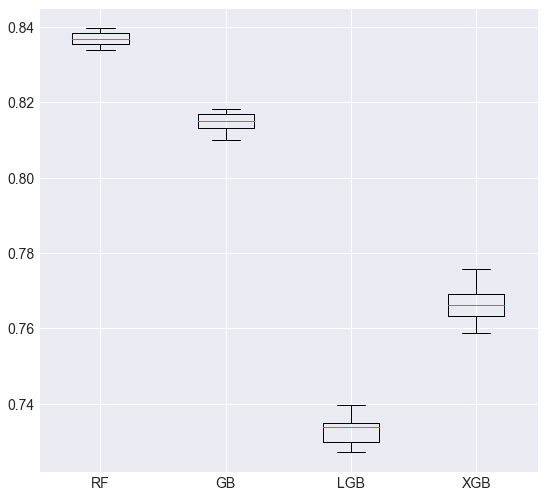

In [10]:
cv_scores_C1_test = cv_scores_C1.drop(['train_RF','train_GB','train_LGB','train_XGB'], axis=1)
cv_scores_C1_train = cv_scores_C1.drop(['test_RF','test_GB','test_LGB','test_XGB'], axis=1)

plt.figure(figsize=(8,8))
plt.boxplot(cv_scores_C1_train)
plt.xticks(range(1, len(names)+1), names)
plt.show()

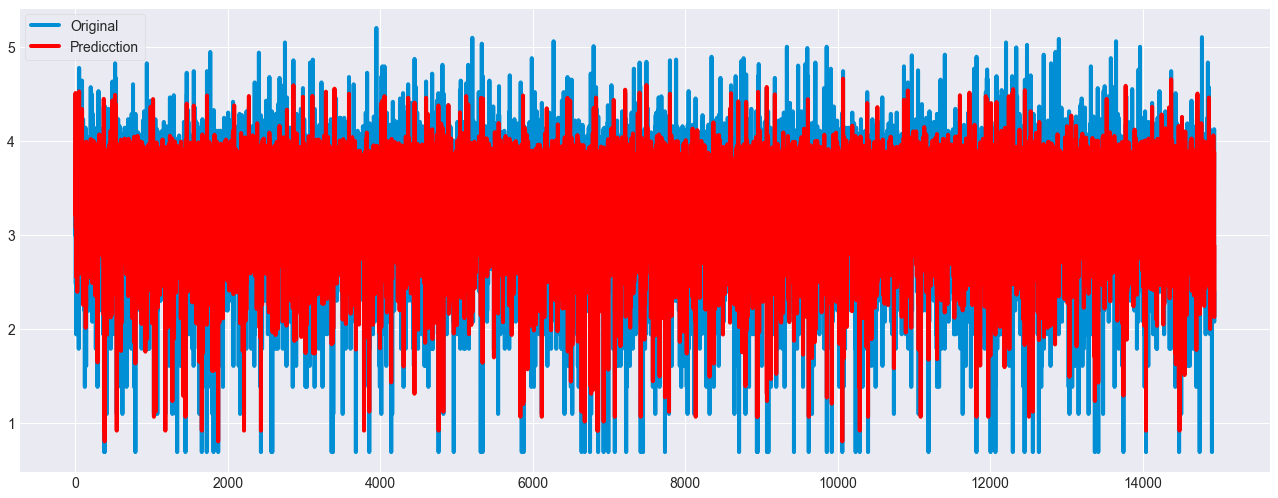

In [15]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster1_estaciones)]

train, test = train_test_split(bicimad_est, test_size = 0.30, random_state = seed)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']

model_C1= RandomForestRegressor(bootstrap=True,
  max_depth=80,
  max_features=7,
  min_samples_leaf=1,
  min_samples_split=8,
  n_estimators=1000)

resultado = model_C1.fit(X_train, y_train)

y_pred_train = model_C1.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mse_train**(0.5)
score_train = model_C1.score(X_train, y_train, sample_weight=None)

y_pred_test = model_C1.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_train**(0.5)
score_test = model_C1.score(X_test, y_test, sample_weight=None)


predictions = resultado.predict(X_test)
 
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

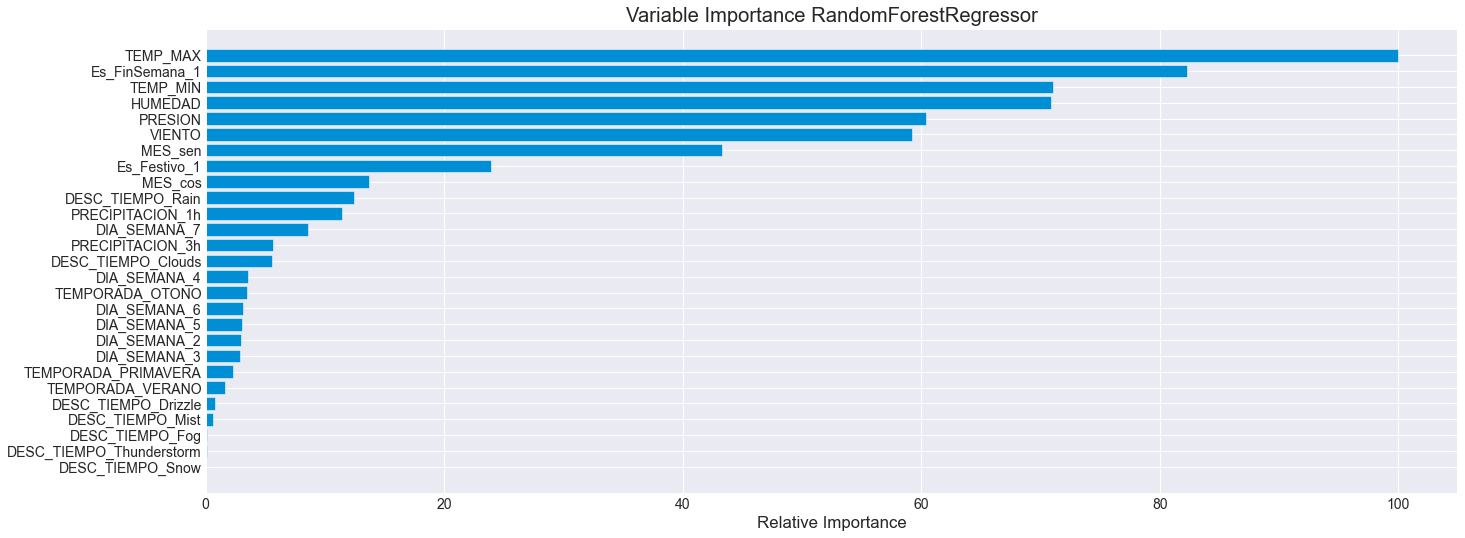

In [16]:
feature_importance = model_C1.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title(f'Variable Importance {model_C1.__class__.__name__}')
plt.show()

In [17]:
print('---------Evaluacióin del melo en datos train---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_train))
print("Mean Absolute Error: %.2f" % mse_train)
print("Root Mean Squared Error: %.2f" % rmse_train)
print('')
print('---------Evaluacióin del melo en datos test---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_test))
print("Mean Absolute Error: %.2f" % mse_test)
print("Root Mean Squared Error: %.2f" % rmse_test)

---------Evaluacióin del melo en datos train---------------
R^2 Coefficient of Determination: 0.84.
Mean Absolute Error: 0.05
Root Mean Squared Error: 0.23

---------Evaluacióin del melo en datos test---------------
R^2 Coefficient of Determination: 0.76.
Mean Absolute Error: 0.13
Root Mean Squared Error: 0.23


## Cluster 2

In [10]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster2_estaciones)]
    
train, test = train_test_split(bicimad_est, test_size = 0.30, random_state = seed)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']
    

models = list()
models.append(('RFR', RandomForestRegressor(bootstrap=True,
  max_depth=80,
  max_features=7,
  min_samples_leaf=1,
  min_samples_split=8,
  n_estimators=1000)))

models.append(('GBR', GradientBoostingRegressor(learning_rate=0.01,
  max_depth=80,
  n_estimators=500,
  subsample=0.1)))

models.append(('LGBMR', LGBMRegressor(learning_rate=0.1,
  max_depth=25,
  n_estimators=1000,
  num_leaves=16)))

models.append(('XGBR', XGBRegressor(gamma=0,
  learning_rate=0.1,
  max_depth=8,
  min_child_weight=3,
  n_estimators=1000,
  reg_alpha=0.1,
  reg_lambda=200)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    
    cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=seed)        
    cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True)
    
    cv_scores = pd.DataFrame(cv_scores)
    if name=='RFR':
        cv_scores_C2 = cv_scores.copy()
    else:
        cv_scores_C2 = pd.concat([cv_scores_C2, cv_scores])
        
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print(cv_scores)
    print()

Model: RFR 
R^2: 0.88.
MSE: 0.06
RMSE: 0.24
    fit_time  score_time  test_score  train_score
0   5.881621    0.348201    0.712215     0.881727
1   5.784654    0.349389    0.720238     0.880786
2   5.825403    0.344940    0.747887     0.875314
3   5.866738    0.346481    0.737055     0.876802
4   5.763717    0.348457    0.752907     0.874076
5   5.883728    0.335185    0.693119     0.884453
6   5.788316    0.339339    0.708796     0.881936
7   5.780802    0.351304    0.752943     0.875334
8   5.741696    0.345954    0.722145     0.878316
9   5.790885    0.339806    0.743013     0.876158
10  5.708409    0.338558    0.713946     0.881749
11  5.777228    0.342564    0.727088     0.878565
12  5.822078    0.348722    0.732476     0.878077
13  5.710223    0.337415    0.741494     0.876517
14  5.734771    0.334279    0.715181     0.880804

Model: GBR 
R^2: 0.87.
MSE: 0.06
RMSE: 0.24
    fit_time  score_time  test_score  train_score
0   2.282084    0.126375    0.705545     0.865539
1   2.30422

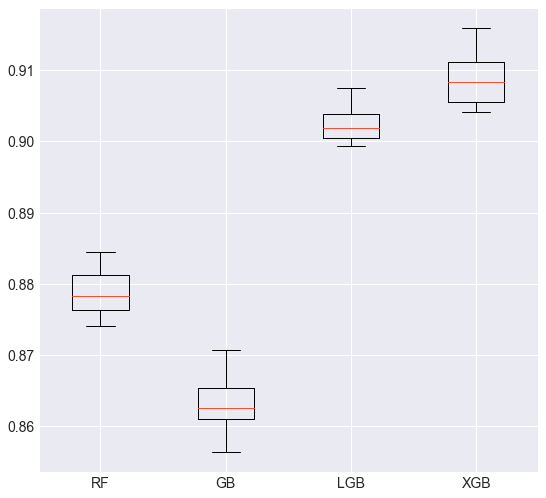

In [18]:
cv_scores_C2_test = cv_scores_C2.drop(['train_RF','train_GB','train_LGB','train_XGB'], axis=1)
cv_scores_C2_train = cv_scores_C2.drop(['test_RF','test_GB','test_LGB','test_XGB'], axis=1)

plt.figure(figsize=(8,8))
plt.boxplot(cv_scores_C2_train)
plt.xticks(range(1, len(names)+1), names)
plt.show()

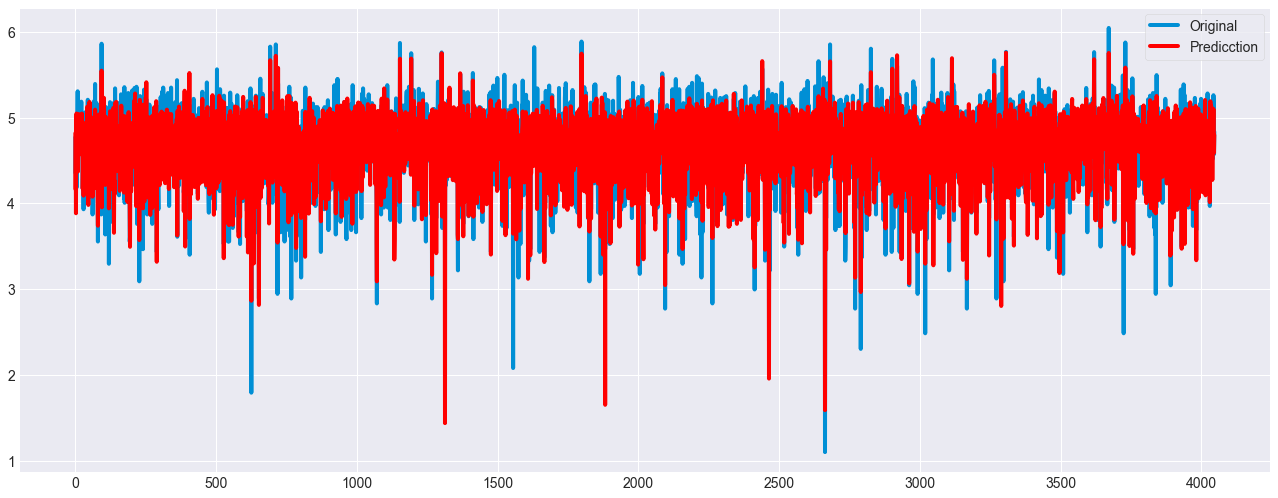

In [19]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster2_estaciones)]

train, test = train_test_split(bicimad_est, test_size = 0.30, random_state = seed)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']


model_C2 = XGBRegressor(gamma=0,
  learning_rate=0.1,
  max_depth=8,
  min_child_weight=3,
  n_estimators=1000,
  reg_alpha=0.1,
  reg_lambda=200)

resultado = model_C2.fit(X_train, y_train)
predictions = resultado.predict(X_test)
score =model_C2.score(X_test, y_test, sample_weight=None)


resultado = model_C2.fit(X_train, y_train)

y_pred_train = model_C2.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mse_train**(0.5)
score_train = model_C2.score(X_train, y_train, sample_weight=None)

y_pred_test = model_C2.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_train**(0.5)
score_test = model_C2.score(X_test, y_test, sample_weight=None)


predictions = resultado.predict(X_test)
 
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

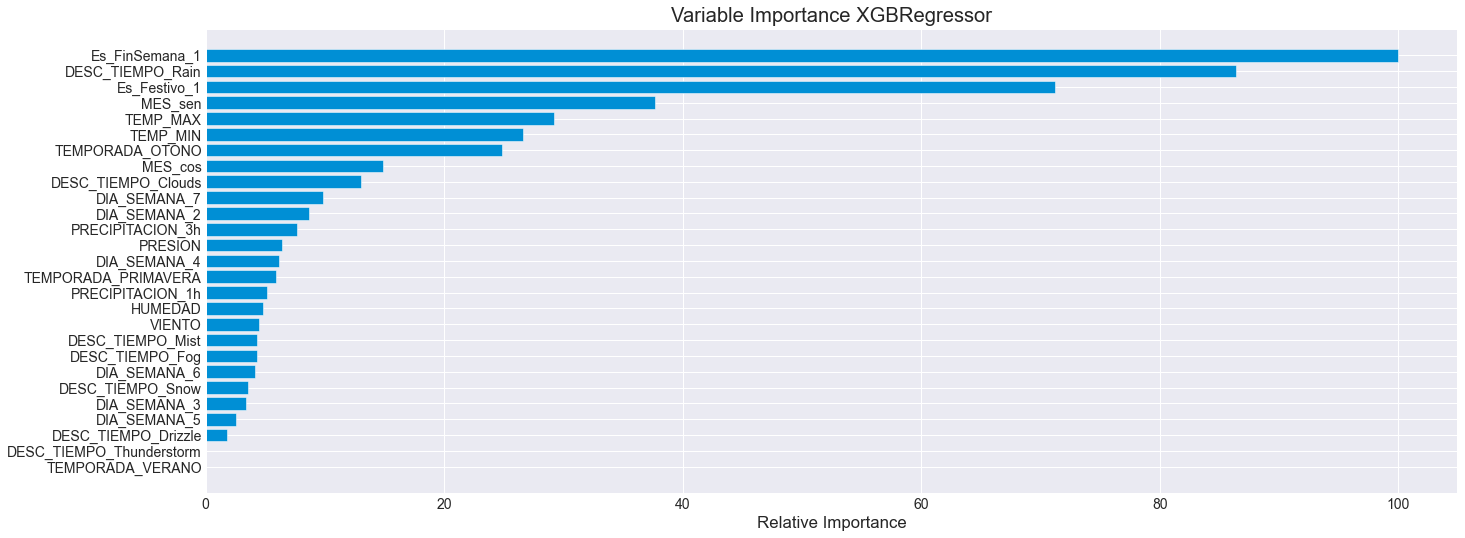

In [20]:
feature_importance = model_C2.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title(f'Variable Importance {model_C2.__class__.__name__}')
plt.show()

In [21]:
print('---------Evaluacióin del melo en datos train---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_train))
print("Mean Absolute Error: %.2f" % mse_train)
print("Root Mean Squared Error: %.2f" % rmse_train)
print('')
print('---------Evaluacióin del melo en datos test---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_test))
print("Mean Absolute Error: %.2f" % mse_test)
print("Root Mean Squared Error: %.2f" % rmse_test)

---------Evaluacióin del melo en datos train---------------
R^2 Coefficient of Determination: 0.89.
Mean Absolute Error: 0.03
Root Mean Squared Error: 0.16

---------Evaluacióin del melo en datos test---------------
R^2 Coefficient of Determination: 0.74.
Mean Absolute Error: 0.06
Root Mean Squared Error: 0.16


## Cluster 3

In [12]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster3_estaciones)]
    
train, test = train_test_split(bicimad_est, test_size = 0.30, random_state = seed)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']
    

models = list()
models.append(('RFR', RandomForestRegressor(bootstrap=True,
  max_depth=80,
  max_features=7,
  min_samples_leaf=1,
  min_samples_split=8,
  n_estimators=1000)))

models.append(('GBR', GradientBoostingRegressor(learning_rate=0.01,
  max_depth=80,
  n_estimators=500,
  subsample=0.1)))

models.append(('LGBMR', LGBMRegressor(learning_rate=0.1,
  max_depth=25,
  n_estimators=1000,
  num_leaves=16)))

models.append(('XGBR', XGBRegressor(gamma=0,
  learning_rate=0.1,
  max_depth=8,
  min_child_weight=3,
  n_estimators=1000,
  reg_alpha=1,
  reg_lambda=200)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    
    cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=seed)        
    cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True)
    
    cv_scores = pd.DataFrame(cv_scores)
    if name=='RFR':
        cv_scores_C3 = cv_scores.copy()
    else:
        cv_scores_C3 = pd.concat([cv_scores_C3, cv_scores])
        
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print(cv_scores)
    print()

Model: RFR 
R^2: 0.89.
MSE: 0.06
RMSE: 0.25
     fit_time  score_time  test_score  train_score
0   24.330021    1.585264    0.723973     0.890844
1   24.227762    1.587311    0.724073     0.891566
2   24.277047    1.587360    0.736674     0.888467
3   24.098597    1.597775    0.731645     0.890269
4   24.011703    1.581911    0.733753     0.887405
5   24.000563    1.581791    0.713381     0.893983
6   24.241369    1.590158    0.731322     0.889420
7   24.982225    1.695790    0.734417     0.889947
8   24.659086    1.600269    0.720580     0.891214
9   24.298819    1.601920    0.730982     0.890099
10  24.142184    1.585196    0.726936     0.890569
11  24.012390    1.615764    0.732428     0.889848
12  24.112809    1.591441    0.724658     0.890947
13  24.100889    1.678877    0.732419     0.890092
14  23.967751    1.577108    0.726601     0.889880

Model: GBR 
R^2: 0.88.
MSE: 0.06
RMSE: 0.25
     fit_time  score_time  test_score  train_score
0   11.176848    0.659966    0.722301     0.

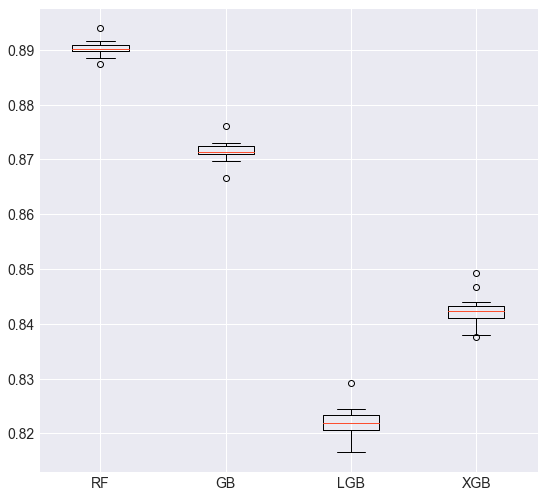

In [22]:
cv_scores_C3_test = cv_scores_C3.drop(['train_RF','train_GB','train_LGB','train_XGB'], axis=1)
cv_scores_C3_train = cv_scores_C3.drop(['test_RF','test_GB','test_LGB','test_XGB'], axis=1)

plt.figure(figsize=(8,8))
plt.boxplot(cv_scores_C3_train)
plt.xticks(range(1, len(names)+1), names)
plt.show()

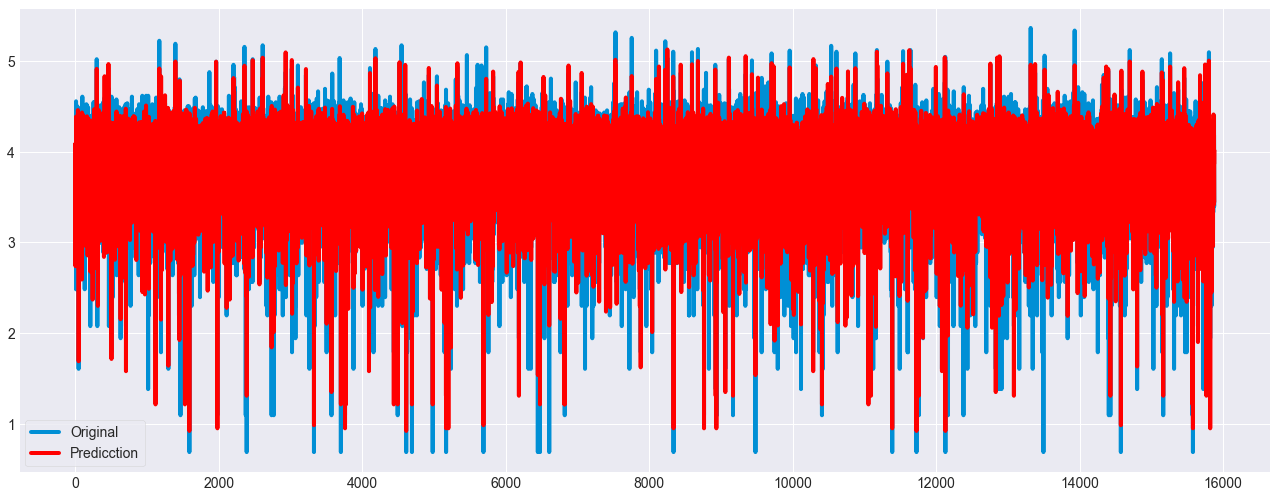

In [23]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster3_estaciones)]

train, test = train_test_split(bicimad_est, test_size = 0.30, random_state = seed)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']


model_C3 = RandomForestRegressor(bootstrap=True,
  max_depth=80,
  max_features=7,
  min_samples_leaf=1,
  min_samples_split=8,
  n_estimators=1000)

resultado = model_C3.fit(X_train, y_train)
predictions = resultado.predict(X_test)
score =model_C3.score(X_test, y_test, sample_weight=None)


resultado = model_C3.fit(X_train, y_train)

y_pred_train = model_C3.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mse_train**(0.5)
score_train = model_C3.score(X_train, y_train, sample_weight=None)

y_pred_test = model_C3.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_train**(0.5)
score_test = model_C3.score(X_test, y_test, sample_weight=None)


predictions = resultado.predict(X_test)
 
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

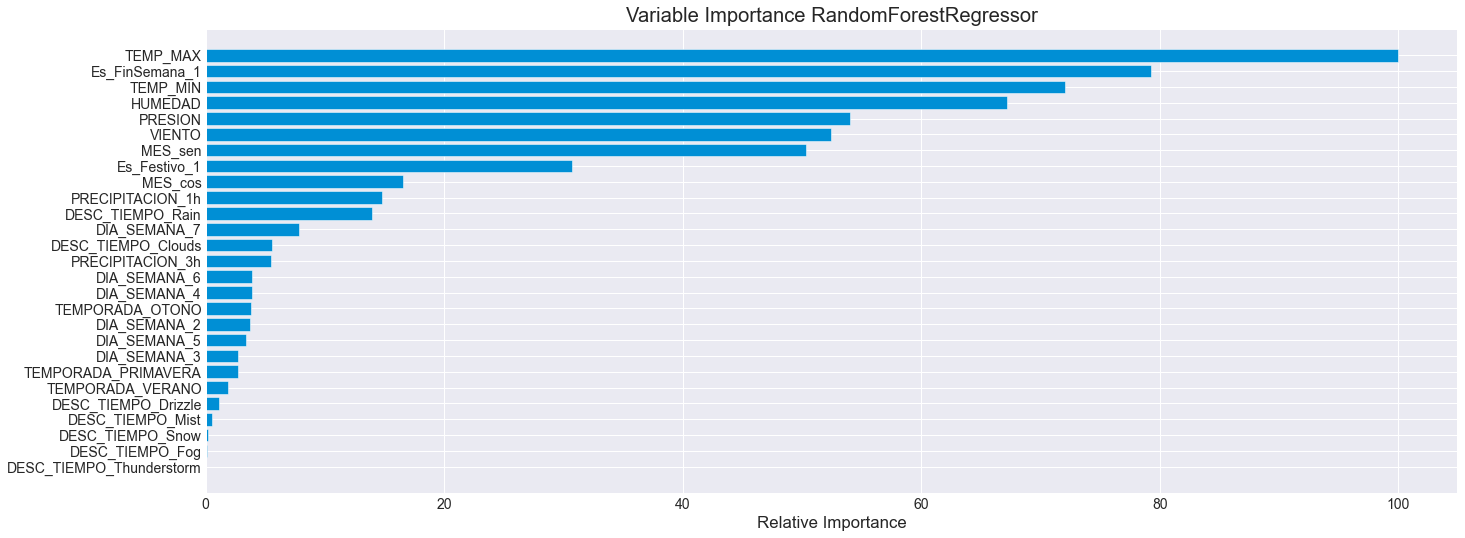

In [24]:
feature_importance = model_C3.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title(f'Variable Importance {model_C3.__class__.__name__}')
plt.show()

In [25]:
print('---------Evaluacióin del melo en datos train---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_train))
print("Mean Absolute Error: %.2f" % mse_train)
print("Root Mean Squared Error: %.2f" % rmse_train)
print('')
print('---------Evaluacióin del melo en datos test---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_test))
print("Mean Absolute Error: %.2f" % mse_test)
print("Root Mean Squared Error: %.2f" % rmse_test)

---------Evaluacióin del melo en datos train---------------
R^2 Coefficient of Determination: 0.89.
Mean Absolute Error: 0.02
Root Mean Squared Error: 0.16

---------Evaluacióin del melo en datos test---------------
R^2 Coefficient of Determination: 0.75.
Mean Absolute Error: 0.06
Root Mean Squared Error: 0.16


## Cluster 4

In [13]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster4_estaciones)]
    
train, test = train_test_split(bicimad_est, test_size = 0.30, random_state = seed)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']
    

models = list()
models.append(('RFR', RandomForestRegressor(bootstrap=True,
  max_depth=80,
  max_features=7,
  min_samples_leaf=1,
  min_samples_split=8,
  n_estimators=1000)))

models.append(('GBR', GradientBoostingRegressor(learning_rate=0.01,
  max_depth=80,
  n_estimators=500,
  subsample=0.1)))

models.append(('LGBMR', LGBMRegressor(learning_rate=0.1,
  max_depth=25,
  n_estimators=1000,
  num_leaves=16)))

models.append(('XGBR', XGBRegressor(gamma=0,
  learning_rate=0.1,
  max_depth=8,
  min_child_weight=1,
  n_estimators=1000,
  reg_alpha=1,
  reg_lambda=200)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    
    cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=seed)        
    cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True)
    
    cv_scores = pd.DataFrame(cv_scores)
    if name=='RFR':
        cv_scores_C4 = cv_scores.copy()
    else:
        cv_scores_C4 = pd.concat([cv_scores_C4, cv_scores])
        
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print(cv_scores)
    print()

Model: RFR 
R^2: 0.91.
MSE: 0.05
RMSE: 0.22
     fit_time  score_time  test_score  train_score
0   12.835216    0.799640    0.777190     0.901350
1   12.829835    0.821594    0.775803     0.901529
2   12.850165    0.801778    0.766386     0.901939
3   12.837688    0.830485    0.777622     0.901522
4   12.761784    0.829460    0.754925     0.903808
5   12.820735    0.813598    0.780702     0.900178
6   12.781342    0.828204    0.763353     0.903902
7   12.727871    0.816795    0.779041     0.901615
8   12.773516    0.807238    0.769842     0.900872
9   13.081610    0.832773    0.770377     0.901448
10  12.769325    0.799649    0.775307     0.902357
11  12.708889    0.815629    0.768255     0.902717
12  12.684976    0.813127    0.768644     0.901381
13  12.712631    0.801111    0.773564     0.903134
14  12.681903    0.800193    0.772582     0.901556

Model: GBR 
R^2: 0.89.
MSE: 0.05
RMSE: 0.22
    fit_time  score_time  test_score  train_score
0   5.647304    0.323088    0.770950     0.88

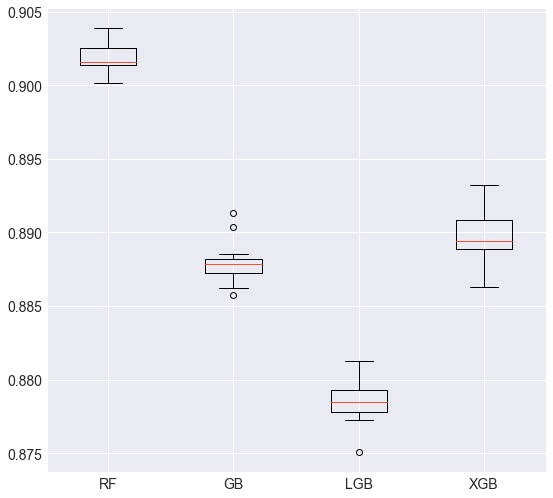

In [26]:
cv_scores_C4_test = cv_scores_C4.drop(['train_RF','train_GB','train_LGB','train_XGB'], axis=1)
cv_scores_C4_train = cv_scores_C4.drop(['test_RF','test_GB','test_LGB','test_XGB'], axis=1)

plt.figure(figsize=(8,8))
plt.boxplot(cv_scores_C4_train)
plt.xticks(range(1, len(names)+1), names)
plt.show()

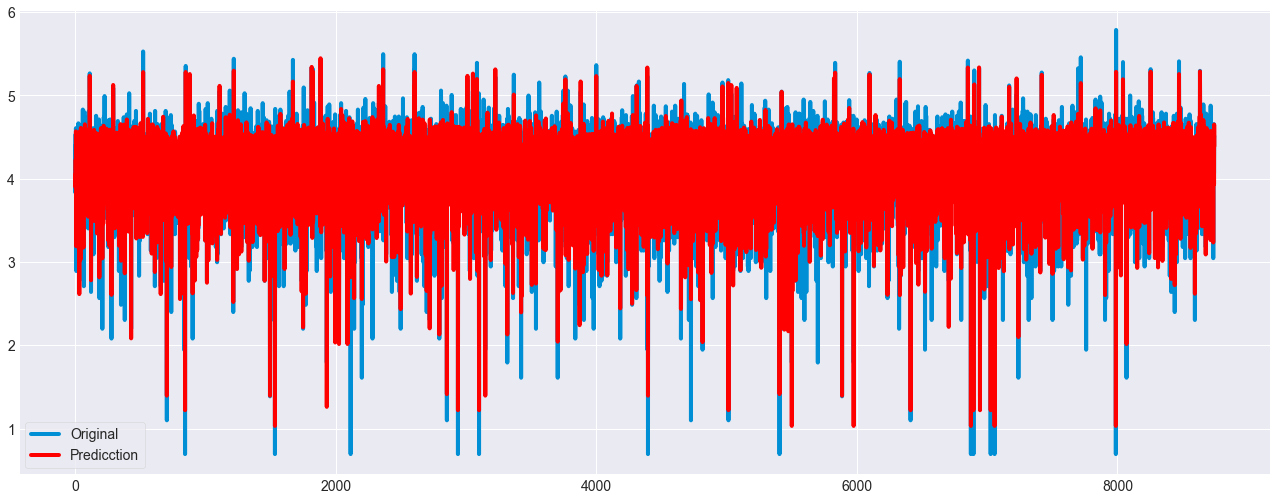

In [27]:
bicimad_est = bicimad[bicimad['ESTACION'].isin(cluster4_estaciones)]

train, test = train_test_split(bicimad_est, test_size = 0.30, random_state = seed)    
X_train = train.drop(['DEMANDA','ESTACION'], axis=1)
X_test = test.drop(['DEMANDA','ESTACION'], axis=1)
y_train = train['DEMANDA']
y_test = test['DEMANDA']


model_C4 = RandomForestRegressor(bootstrap=True,
  max_depth=80,
  max_features=7,
  min_samples_leaf=1,
  min_samples_split=8,
  n_estimators=1000)

resultado = model_C4.fit(X_train, y_train)
predictions = resultado.predict(X_test)
score =model_C4.score(X_test, y_test, sample_weight=None)


resultado = model_C4.fit(X_train, y_train)

y_pred_train = model_C4.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mse_train**(0.5)
score_train = model_C4.score(X_train, y_train, sample_weight=None)

y_pred_test = model_C4.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_train**(0.5)
score_test = model_C4.score(X_test, y_test, sample_weight=None)


predictions = resultado.predict(X_test)
 
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

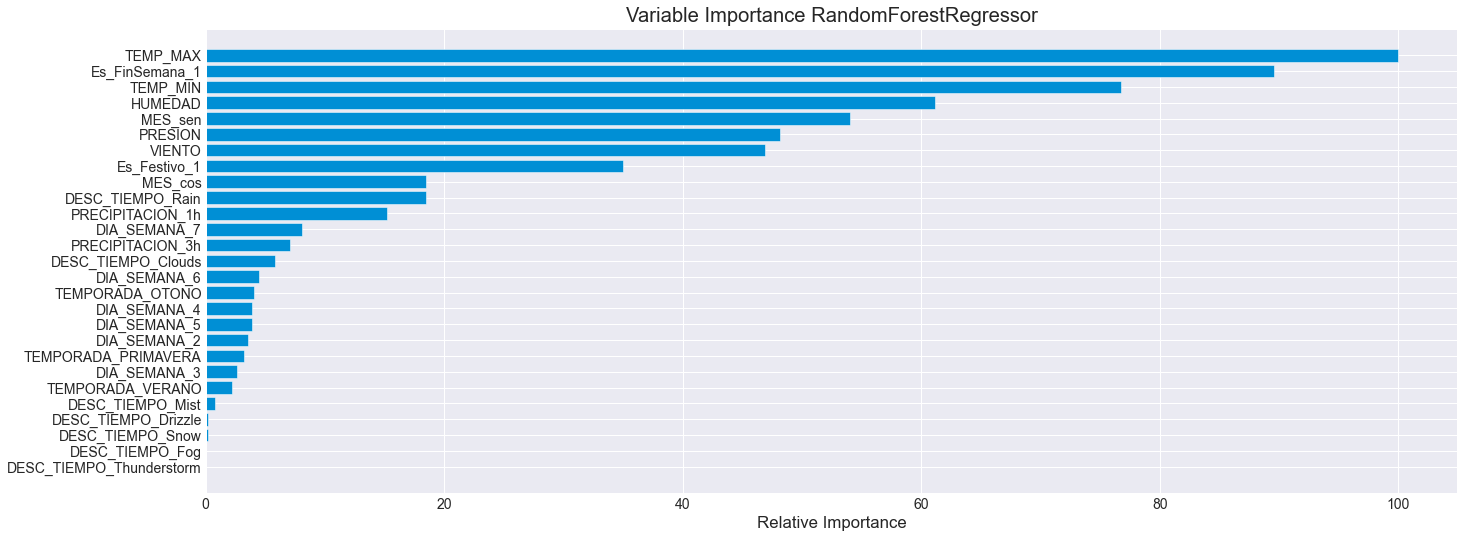

In [28]:
feature_importance = model_C4.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title(f'Variable Importance {model_C4.__class__.__name__}')
plt.show()

In [29]:
print('---------Evaluacióin del melo en datos train---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_train))
print("Mean Absolute Error: %.2f" % mse_train)
print("Root Mean Squared Error: %.2f" % rmse_train)
print('')
print('---------Evaluacióin del melo en datos test---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_test))
print("Mean Absolute Error: %.2f" % mse_test)
print("Root Mean Squared Error: %.2f" % rmse_test)

---------Evaluacióin del melo en datos train---------------
R^2 Coefficient of Determination: 0.91.
Mean Absolute Error: 0.02
Root Mean Squared Error: 0.15

---------Evaluacióin del melo en datos test---------------
R^2 Coefficient of Determination: 0.78.
Mean Absolute Error: 0.05
Root Mean Squared Error: 0.15
